In [1]:
import os, sys
from os.path import dirname
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unittest.mock import MagicMock, patch
from performance_data.data_table import PhaseData, DataTable
from performance_data.data_model import PhaseGenerator, TierModel, DataModel, load_and_predict 

#DeepNNModel, 
#from performance_data.data_model import DeepNNModel
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from functools import partial
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.io as pio
import loguru
from pprint import pprint
loguru.logger.remove()
loguru.logger.add(sys.stderr, level="INFO")

1

In [2]:
CURRENT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
##### dataset file name for performance model
DATASET_FILE = os.path.join(CURRENT_DIR, "tests", "deep_data",
                            "deep_500_dataset_completed.csv")
##### directory where the models are saved
MODELS_DIRECTORY = os.path.join(CURRENT_DIR, "performance_data", 
                                "notebooks", "xplique_models")

# Custom class to train and save models per tier
data_model = DataModel()

# choosing type of models per tier
model_1 = TierModel(regressor=DecisionTreeRegressor(criterion="poisson"))
model_2 = TierModel(regressor=DecisionTreeRegressor(criterion="poisson"))
model_3 = TierModel(regressor=DecisionTreeRegressor(criterion="poisson"))
model_4 = TierModel(regressor=DecisionTreeRegressor(criterion="poisson"))
models_list = [model_1, model_2, model_3, model_4]

# Initialize the DataModel
data_model = DataModel(data_file=DATASET_FILE,
                       models=models_list)
# Train the model
trained_models = data_model.train_model(test_size=0.2,
                                        save_dir=MODELS_DIRECTORY)

2023-09-26 11:08:51.554 | INFO     | performance_data.data_model:__init__:257 - Initializing DataModel object.
2023-09-26 11:08:51.556 | INFO     | performance_data.data_model:load_data:304 - Ingesting input data.
2023-09-26 11:08:51.579 | INFO     | performance_data.data_model:load_data:307 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-09-26 11:08:51.581 | INFO     | performance_data.data_model:_prepare_data:406 - Preparing data...
2023-09-26 11:08:51.596 | INFO     | performance_data.data_model:__init__:268 - Initializing models.
2023-09-26 11:08:51.597 | INFO     | performance_data.data_model:__init__:257 - Initializing DataModel object.
2023-09-26 11:08:51.598 | INFO     | performance_data.data_model:load_data:304 - Ingesting input data.
2023-09-26 11:08:51.609 | INFO     | performance_data.data_model:load_data:307 - Target tiers: ['gpfs_nfs_bw', 'afsm_beegfs_bw', 'gpfs_nfs_sbb_bw', 'afsm_beegfs_sbb_bw']
2023-09-26 11:08:51.609 | INFO     | performance_data.data_model:_prepare_data:406

In [3]:
from xplique.attributions import (Saliency,
                             IntegratedGradients,
                             KernelShap,
                             Lime,
                             Occlusion,
                             SmoothGrad,
                             VarGrad,
                             SquareGrad,
                             GuidedBackprop,
                             DeconvNet,
                             GradientInput
)

In [4]:
import tensorflow as tf

In [5]:
tier_name = 'gpfs_nfs_bw'
tier_model = data_model.models[tier_name]


# Use Kernel SHAP to explain predictions on new data
X_test = data_model.X_test
y_test = data_model.y_test[tier_name]
y_test_pred = data_model.models[tier_name].predict(data_model.X_test)
y_train_pred = data_model.models[tier_name].predict(data_model.X_train)
# Define the scaling factors for the x-axis and y-axis
x_scale_factor = 1e-6
y_scale_factor = 1e-6

# Apply the scaling factors to the data
scaled_y_test = y_test * x_scale_factor
scaled_y_train = data_model.y_train[tier_name] * x_scale_factor
scaled_y_test_pred = y_test_pred * y_scale_factor
scaled_y_train_pred = y_train_pred * y_scale_factor

# explanation
explainer = KernelShap(tier_model)
explanation = explainer(tf.cast(X_test, tf.float32), tf.cast(y_test, tf.float32))

c:\Users\a770398\OneDrive - Atos\IO-SEA - Copy\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\a770398\OneDrive - Atos\IO-SEA - Copy\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\a770398\OneDrive - Atos\IO-SEA - Copy\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\a770398\OneDrive - Atos\IO-SEA - Copy\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\a770398\OneDrive - Atos\IO-SEA - Copy\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but

In [6]:
features_name = list(data_model.input_data.columns)
print(explanation)

tf.Tensor(
[[ 1.65981407e+23  2.42248292e+24  4.40894027e+22 ... -2.51374448e+23
  -5.27587374e+22 -1.16801137e+24]
 [-4.10286766e+19 -1.51498822e+20 -4.16743054e+19 ...  7.96440483e+20
   6.66046708e+20 -6.13521662e+21]
 [ 5.92351510e+19  6.85542580e+20 -1.02664655e+21 ...  1.55650247e+22
   5.26094605e+20 -1.90003806e+22]
 ...
 [ 9.33399434e+19  2.01531158e+20 -2.94563189e+19 ...  3.12298373e+21
  -3.20590015e+19 -3.70887558e+21]
 [ 1.15957431e+23  4.17204552e+22 -4.00435669e+22 ...  7.49527010e+24
  -1.65446542e+23 -7.15929609e+24]
 [ 6.72618047e+18 -5.88618448e+19 -1.94719573e+19 ...  6.29778490e+19
  -1.46345262e+19 -2.55353283e+21]], shape=(100, 14), dtype=float32)


In [7]:
from xplique.plots import plot_feature_impact, plot_mean_feature_impact, summary_plot_tabular

for exp_index, exp_method in enumerate(explanation):
    print(exp_method/1e24)
    #plot_feature_impact(exp[0], features_name, X_test)
    #plt.title(exp_method)
    #plt.show()

tf.Tensor(
[ 0.16598141  2.422483    0.0440894  -0.35042137  0.08763077 -0.25543317
 -0.1085347  -1.227326   -0.03719525 -0.13016449  0.11734802 -0.25137445
 -0.05275874 -1.1680113 ], shape=(14,), dtype=float32)
tf.Tensor(
[-4.1028678e-05 -1.5149883e-04 -4.1674306e-05  9.4805415e-05
  6.1053208e-05 -1.1151594e-04 -2.8770851e-04 -1.3881859e-04
 -4.8784605e-06 -5.6918035e-04  7.0106747e-05  7.9644046e-04
  6.6604669e-04 -6.1352164e-03], shape=(14,), dtype=float32)
tf.Tensor(
[ 5.9235150e-05  6.8554259e-04 -1.0266466e-03  7.2572322e-04
  1.4571019e-03 -1.0418727e-04 -1.1169119e-03  8.0440880e-04
  2.9310930e-04 -2.4769470e-04  2.5550753e-04  1.5565025e-02
  5.2609458e-04 -1.9000381e-02], shape=(14,), dtype=float32)
tf.Tensor(
[ 0.00070357  0.00077107  0.00045389  0.00071678 -0.00190225 -0.00108008
 -0.0009555   0.00044365 -0.0018418  -0.00114332  0.00028047  0.02010137
  0.01349485  0.01163441], shape=(14,), dtype=float32)
tf.Tensor(
[ 3.3129766e-06 -3.3403064e-06 -4.7262197e-06  1.774616

In [9]:
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [11]:

tier_name = 'gpfs_nfs_bw'
tier_model = data_model.models[tier_name].model


# Use Kernel SHAP to explain predictions on new data
X_test = data_model.X_test
y_test = data_model.y_test[tier_name]
y_test_pred = data_model.models[tier_name].predict(data_model.X_test)
y_train_pred = data_model.models[tier_name].predict(data_model.X_train)
# Define the scaling factors for the x-axis and y-axis
x_scale_factor = 1e-6
y_scale_factor = 1e-6

# Apply the scaling factors to the data
scaled_y_test = y_test * x_scale_factor
scaled_y_train = data_model.y_train[tier_name] * x_scale_factor
scaled_y_test_pred = y_test_pred * y_scale_factor
scaled_y_train_pred = y_train_pred * y_scale_factor

# explanation
explainer = shap.Explainer(tier_model)
shap_values = explainer(X_test)

In [18]:
print(shap_values[0])
!initjs()

.values =
array([ 1.40899760e+07,  2.32164183e+09, -1.28181552e+09, -1.66545520e+08,
        2.45136349e+08, -2.78211934e+09,  4.64185272e+08,  1.86840727e+09,
        0.00000000e+00, -6.47208713e+08,  1.61930302e+09, -5.07151482e+10,
        1.28429982e+09,  3.59356029e+10])

.base_values =
array([3.55849013e+10])

.data =
array([0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 6.40000000e-02, 5.00000000e-04, 6.68380800e-03,
       9.93316192e-01, 9.24421808e-04])


'initjs' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


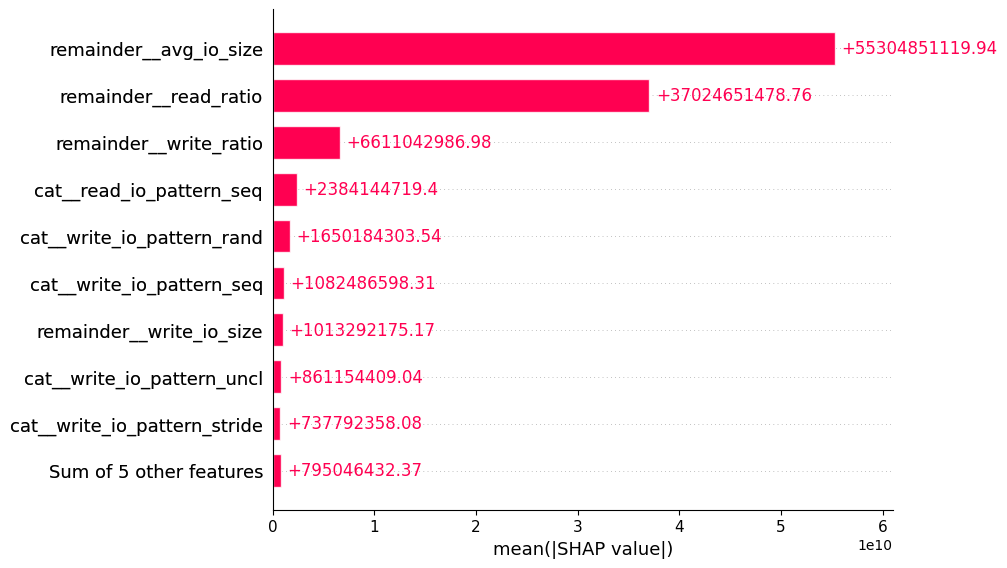

In [20]:
# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)

In [27]:
# print the JS visualization code to the notebook
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(tier_model.predict, data_model.X_train)
shap_values = explainer.shap_values(X_test)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 100/100 [05:04<00:00,  3.04s/it]


TypeError: 'float' object is not subscriptable